In [1]:
##连接Spark
import taiji_ide #用于选择spark的版本
taiji_ide.set_spark(version="3.1.2",gaia_id="3527") #导入spark环境，选择spark版本
import os
from pyspark.sql import *
os.environ['GROUP_ID'] = 'g_wxg_wxa_wxa_offline_datamining'
os.environ['GAIA_ID'] = '3527'
session = SparkSession.builder.config('spark.driver.memory', '32g').config('spark.executor.cores', 8).config('spark.executor.memory', '32g').getOrCreate()

Driver Log Write In: /tmp/log/spark-2df78dfe-3cd0-4450-a685-eade2d8f182b.log
TDWHelper Tracking Url : http://tdwhelper.oa.com/resources_pool_status/app/yarn_app_heuristic.php?app_id=application_1704516375429_1541401
Spark UI : http://application.tdw.oa.com:8080/proxy/application_1704516375429_1541401


In [2]:
from pyspark.sql import SparkSession
import os
import pandas as pd
import numpy as np
import pickle
from IPython.display import Image
from TreeBase_Uplift_Model import UpliftTree,CausalTree

# UpliftTree

In [75]:
##读取tdw里的分区表
from pytoolkit import TDWSQLProvider
provider = TDWSQLProvider(session, group='tl', db='wxg_mmbiz_dw')
# priParts的分区填写要加上p_, 比如 priParts=['p_20231124']
provider.table('dwmid_daily_wxapp_short_moive_uin_stat_dyn_feature_at', priParts=['p_20231124']).createOrReplaceTempView('dwmid_daily_wxapp_short_moive_uin_stat_dyn_feature_at')
sql_str='select * from dwmid_daily_wxapp_short_moive_uin_stat_dyn_feature_at'
df_raw_0=session.sql(sql_str)
df_raw_0=df_raw_0.toPandas()

In [76]:
# 删除不需要的列
df_raw_0 = df_raw_0.drop(columns=['ds', 'uin', 'last_tonow', 'city_level'])

# 删除包含空值的行
df_raw_0 = df_raw_0.dropna()
df_raw_0

,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,history_wxapp_num,first_tonow,gender,age
0,0,60492,0,29290,13,2736,2,149,2,83,323.0,2,58.0
2,0,7,0,0,2,4,1,3,1,3,310.0,2,61.0
3,0,2470,0,0,1,45,1,8,1,6,314.0,2,38.0
4,0,3992,0,0,52,185,1,3,1,5,316.0,2,54.0
5,0,2552,0,0,2,988,1,64,1,43,319.0,2,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991410,0,47574,0,0,26,2325,2,72,1,5,319.0,2,65.0
1991411,0,32665,1990,15940,34,1530,2,74,2,40,321.0,1,66.0
1991412,0,462850,0,21740,384,7911,7,123,1,32,323.0,1,68.0
1991413,0,36995,0,0,31,1233,3,110,2,11,319.0,1,50.0


In [88]:
df_raw_0.groupby('treatment').mean()

,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,history_wxapp_num,first_tonow,age,NaN
treatment,,,,,,,,,,,,
0,16809.042735,222.578841,2201.722762,37.566758,721.814558,1.799263,25.264215,1.315987,10.824584,208.196293,47.715570,0.799963
1,55314.329724,337.598135,11467.699272,42.459293,2371.408178,1.437481,70.000135,0.868860,36.605319,246.343878,41.183687,0.801250


In [95]:
df_raw_0['treatment'] = df_raw_0['treatment'].astype(int)
print(df_raw_0.dtypes)

treatment              int64
staytime_long          int64
pay_amount_1d          int64
pay_amount_30d         int64
pv                     int64
history_pv             int64
drama_num              int64
history_drama_num      int64
wxapp_num              int64
history_wxapp_num      int64
first_tonow          float64
gender                object
age                  float64
NaN                    int64
dtype: object


In [77]:
column_names = df_raw_0.columns.tolist()

In [78]:
##设置变量
#干预变量
t='treatment'
# 结果变量
y='pv'
# 混淆变量
x=[col for col in column_names if col not in [t, y]]

In [79]:
x

['staytime_long',
 'pay_amount_1d',
 'pay_amount_30d',
 'history_pv',
 'drama_num',
 'history_drama_num',
 'wxapp_num',
 'history_wxapp_num',
 'first_tonow',
 'gender',
 'age']

In [89]:
# 建模, 连续型结果变量criterion用CTS
graph,x_imp,df_leaf=UpliftTree(df=df_raw_0,t=t,y=y,x=x,train=None,is_y_clssifier=False,
                               max_depth=5,criterion='CTS',min_split_per=0.01,graph_out=True,imp_out=True,honesty=False)

Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars


In [90]:
x_imp

staytime_long        0.000000
pay_amount_1d        0.000000
pay_amount_30d       0.000000
history_pv           0.000000
drama_num            0.960764
history_drama_num    0.000438
wxapp_num            0.000000
history_wxapp_num    0.000000
first_tonow          0.000000
gender               0.035209
age                  0.003590
dtype: float64

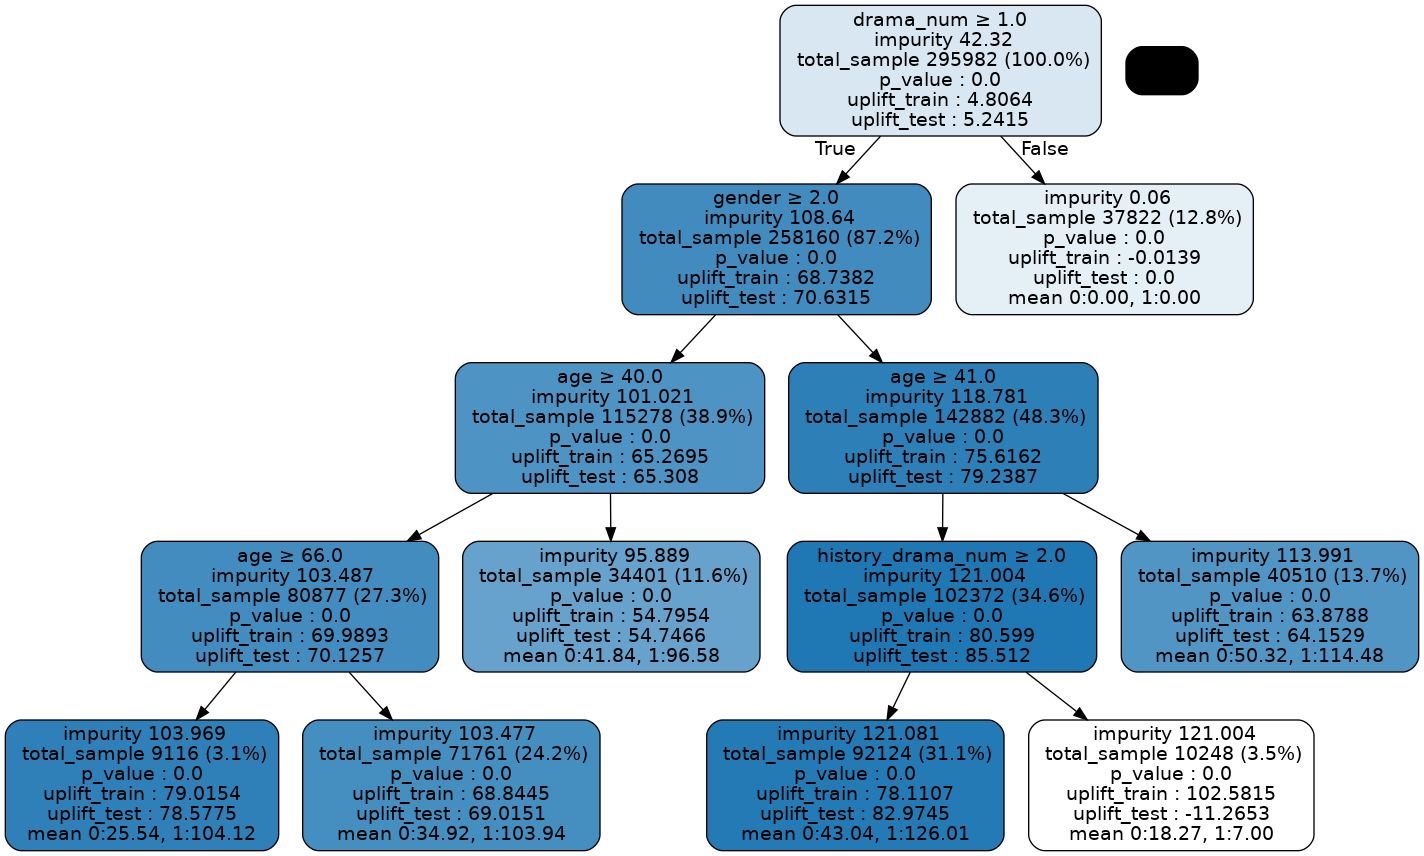

In [91]:
# 模型输出
Image(graph.create_png())

In [ ]:
# 保存模型结果
graph.write_pdf('输出文件/uplift_tree_v1.pdf')
x_imp.to_csv('输出文件/uplift_x_importance_v1.csv')
df_leaf.to_csv('输出文件/uplift_df_leaf_v1.csv',index=False)

In [92]:
df_leaf

,path,p_value,uplift_train,uplift_test,num_t_test,num_c_test,sum_t_test,sum_c_test
0,drama_num >= 1.0 and gender >= 2.0 and age >= ...,0.0,79.0154,78.5775,240,8876,24989,226723
1,drama_num >= 1.0 and gender >= 2.0 and age >= ...,0.0,68.8445,69.0151,5106,66655,530718,2327921
2,drama_num >= 1.0 and gender >= 2.0 and age < 4...,0.0,54.7954,54.7466,2659,31742,256817,1328005
3,drama_num >= 1.0 and gender < 2.0 and age >= 4...,0.0,78.1107,82.9745,4414,87710,556226,3774996
4,drama_num >= 1.0 and gender < 2.0 and age >= 4...,0.0,102.5815,-11.2653,2,10246,14,187146
5,drama_num >= 1.0 and gender < 2.0 and age < 41.0,0.0,63.8788,64.1529,1922,38588,220024,1941889
6,drama_num < 1.0,0.0,-0.0139,0.0,22588,15234,0,0


# CausalTree

In [96]:
# 建模
graph,df_leaf=CausalTree(df_raw_0,t,y,x,train=None,is_y_clssifier=False,max_depth=4,min_split_per=0.01,graph_out=True)

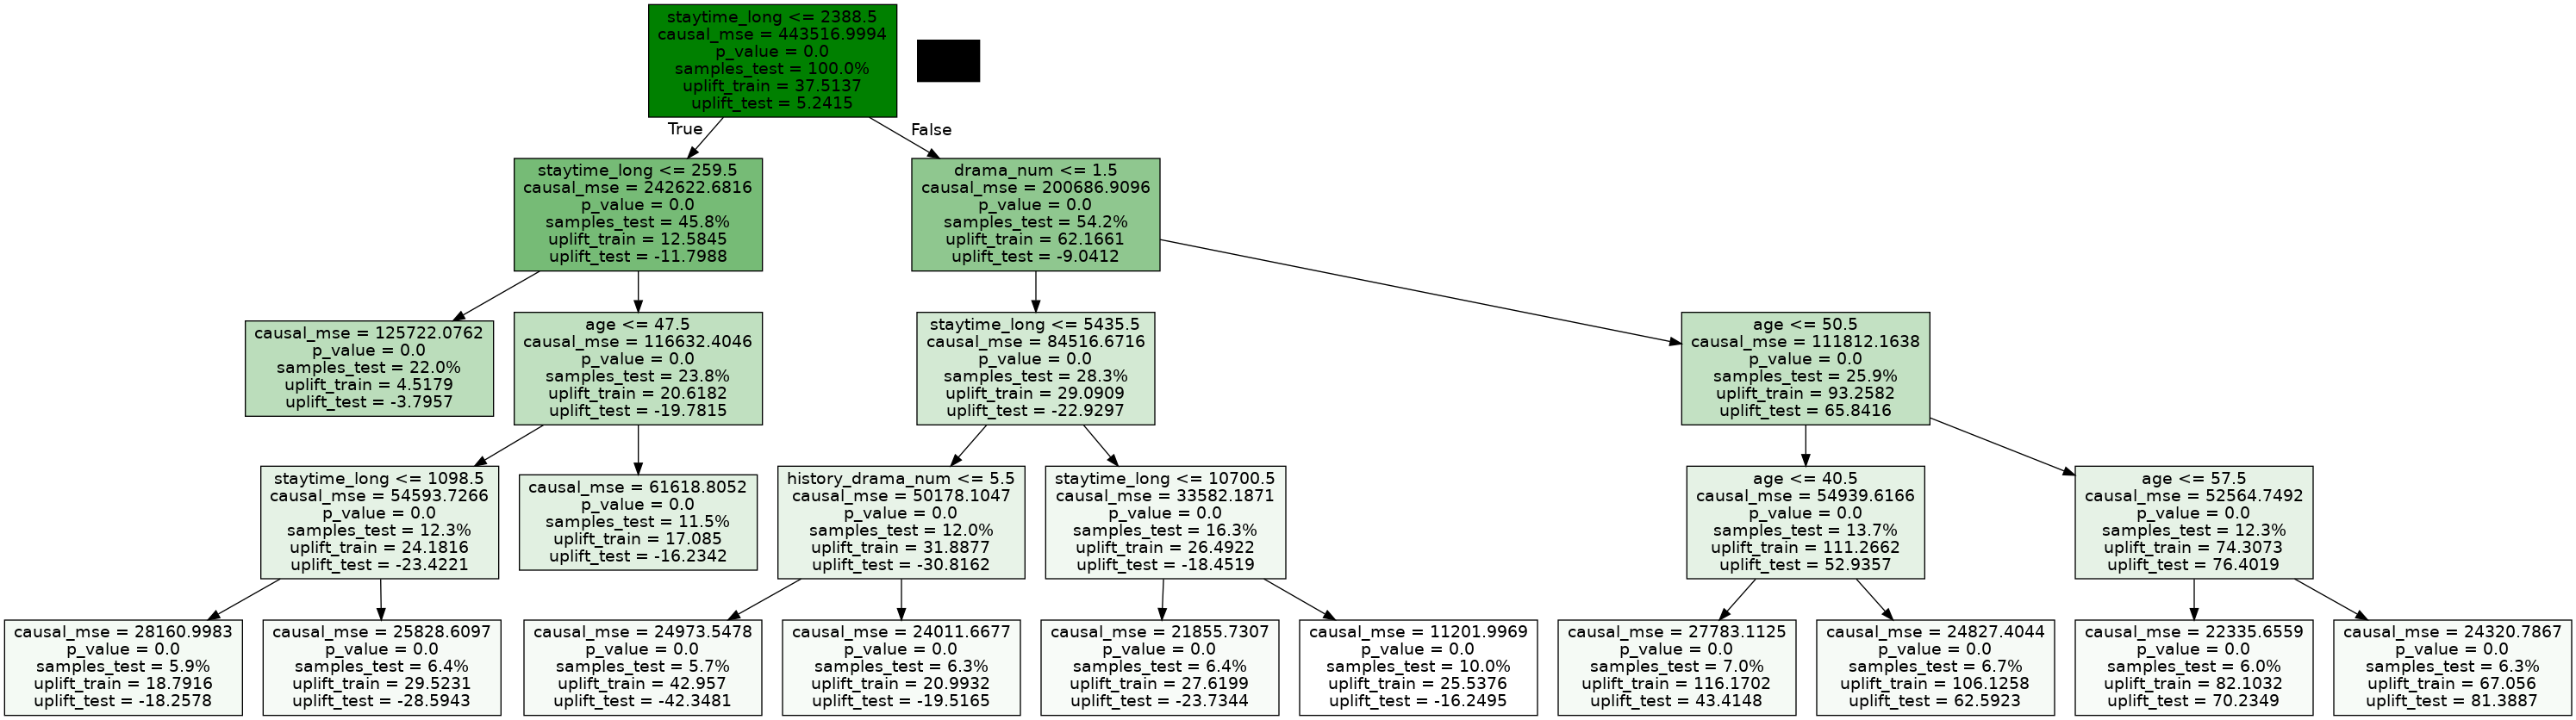

In [97]:
# 模型输出
Image(graph.create_png())

In [98]:
df_leaf

,path,p_value,uplift_train,uplift_test,sum_t_test,sum_c_test,num_t_test,num_c_test
0,staytime_long > 2388.5000 and drama_num > 1.50...,0.0,67.055979,81.388708,211419,1177045,1412,17223
1,staytime_long > 2388.5000 and drama_num > 1.50...,0.0,82.103201,70.234918,301674,1295240,1974,15683
2,staytime_long > 2388.5000 and drama_num > 1.50...,0.0,106.125807,62.592285,491007,1791866,2913,16910
3,staytime_long > 2388.5000 and drama_num > 1.50...,0.0,116.170168,43.414763,452868,2067971,2833,17760
4,staytime_long <= 2388.5000 and staytime_long <...,0.0,4.517882,-3.795696,963,286734,1369,63731
5,staytime_long <= 2388.5000 and staytime_long >...,0.0,17.084973,-16.234157,1072,553198,1379,32519
6,staytime_long > 2388.5000 and drama_num <= 1.5...,0.0,25.537580,-16.249471,106299,444531,11842,17622
7,staytime_long <= 2388.5000 and staytime_long >...,0.0,18.791647,-18.257824,1091,300123,1691,15877
8,staytime_long > 2388.5000 and drama_num <= 1.5...,0.0,20.993161,-19.516501,5074,324843,3154,15377
9,staytime_long > 2388.5000 and drama_num <= 1.5...,0.0,27.619857,-23.734445,12356,407110,3798,15085


In [ ]:
# 保存模型结果
df_leaf.to_csv('输出文件/causal_df_leaf.csv',index=False)
graph.write_pdf('输出文件/causal_tree.pdf')